In [9]:
import numpy as np
import pandas as pd
import os
import mvpa_base_functions as bf
import pickle
from scipy import stats
from nilearn import plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

%matplotlib inline

In [10]:
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker, NiftiMasker
from nilearn.image import concat_imgs, load_img
import nibabel as nib

brain_file = './masks/whole_brain_mask_Sch7net400_subcortex_cerebellum_MNI152NLin2009cAsym_res-2space.nii.gz'
bimg = load_img(brain_file)
bdata = bimg.get_fdata().copy()
bdata[bdata>0] = 1
brain_img = nib.Nifti1Image(bdata, bimg.affine)

masker = NiftiMasker(brain_img, standardize=False)
val = masker.fit_transform(brain_file)


fearnet_file = './masks/fearNet_10regions_dilute6mm_MNI152NLin2009cAsym_res-2_space.nii.gz'
fear_img = load_img(fearnet_file)

voxel_reg_ids = masker.transform(fear_img).reshape(-1)
nofearnet_index = voxel_reg_ids == 0

In [11]:
# the order of the 7 predictive maps:
# ['cond_1block', 'cond_2block', 'cond_3block', 'cond_4block',
   # 'ext_1block', 'recall_1block_CSpE', 'cond_1block_CSpU']
D = pickle.load(open('./results/whole_brain_predictive_patterns.pkl', 'rb'))
all_zvals = D['all_zvals']
all_pvals = D['all_pvals']
all_pvals_fdr = D['all_pvals_fdr']
all_pred_patterns = D['all_pred_patterns']
all_pred_patterns.shape

In [4]:
itrl = 0 #select predictive map to plot, 0-6

coef_vals = all_pred_patterns[itrl].copy()
coef_vals = coef_vals / np.std(coef_vals, axis=-1, keepdims=True)
pvals_fdr = all_pvals_fdr[itrl].copy()
coef_vals[pvals_fdr>0.05] = 0

/home/wen/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



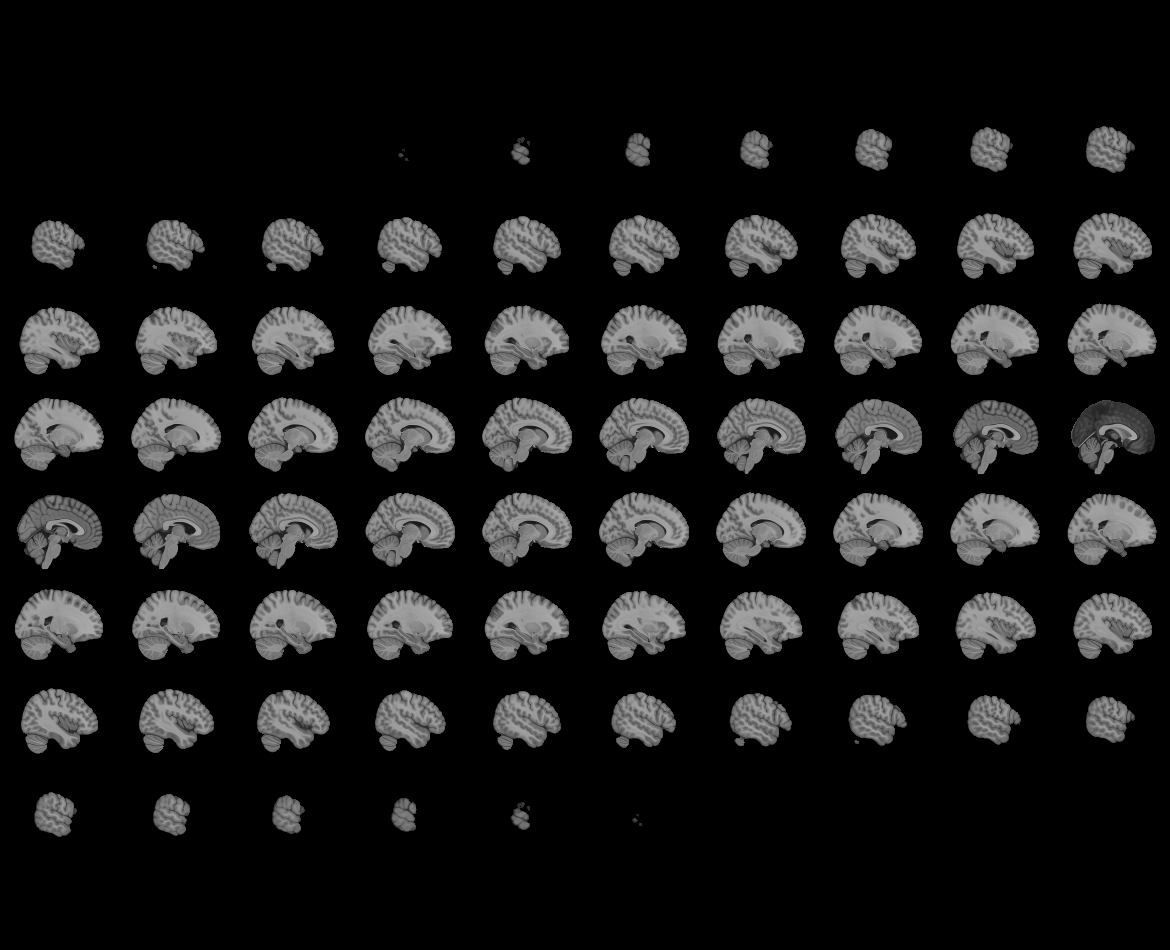
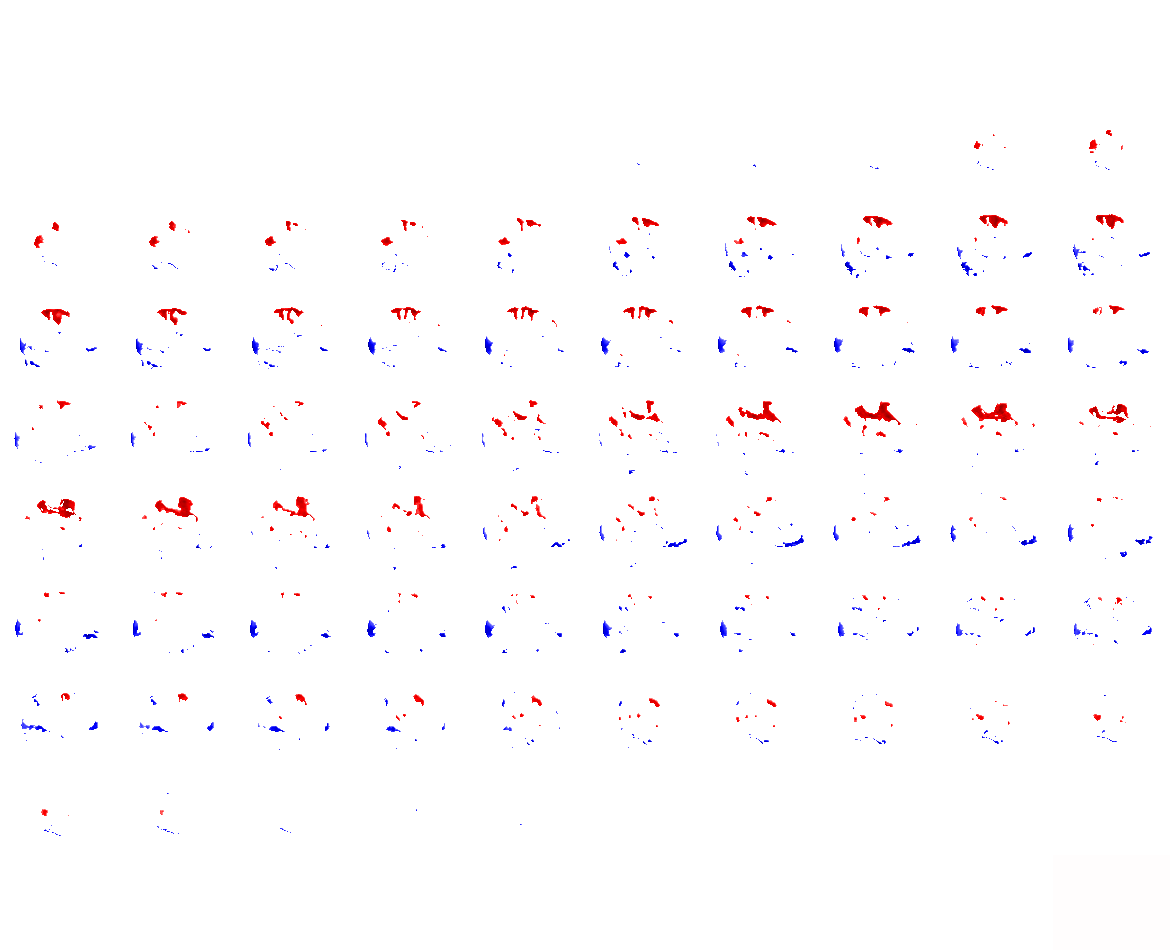

In [5]:
vals = np.zeros((len(nofearnet_index),))
vals[nofearnet_index] = coef_vals.reshape((-1,))
img = masker.inverse_transform(vals)

plotting.view_img(img, threshold=.0, cmap='seismic')

In [6]:
def plot_surface_roi_both_hemi(img, figsize, **kwargs):
    from nilearn import datasets
    from nilearn import surface
    
    fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
    thick_thrs = 1
    left_texture = surface.vol_to_surf(img, fsaverage['pial_left'], interpolation='nearest', radius=1, n_samples=10)
    v = surface.load_surf_data(fsaverage.thick_left)
    left_texture[v<thick_thrs] = np.nan
    
    right_texture = surface.vol_to_surf(img, fsaverage['pial_right'], interpolation='nearest', radius=1, n_samples=10)
    v = surface.load_surf_data(fsaverage.thick_right)
    right_texture[v<thick_thrs] = np.nan

    texture_both_hemi = [left_texture, right_texture]
    
    fig, axes = plt.subplots(2,2, figsize=figsize, subplot_kw={'projection': '3d'})

    for ihemi, hemi in enumerate(['left', 'right']):
        for iview, view in enumerate(['lateral', 'medial']):
            # plotting.plot_surf_stat_map(fsaverage[f'infl_{hemi}'], texture_both_hemi[ihemi], hemi=hemi, view=view, darkness=0.8,
            #                             bg_map=fsaverage[f'sulc_{hemi}'], axes=axes[iview,ihemi], **kwargs)
            plotting.plot_surf_roi(fsaverage[f'infl_{hemi}'], texture_both_hemi[ihemi], hemi=hemi, view=view,
                                   bg_map=fsaverage[f'sulc_{hemi}'], axes=axes[iview,ihemi], bg_on_data=False, **kwargs)
            axes[iview,ihemi].patch.set_alpha(0.0)

    # fig.tight_layout()
    fig.subplots_adjust(hspace=-0.45, wspace=-0.15)
    return fig, axes

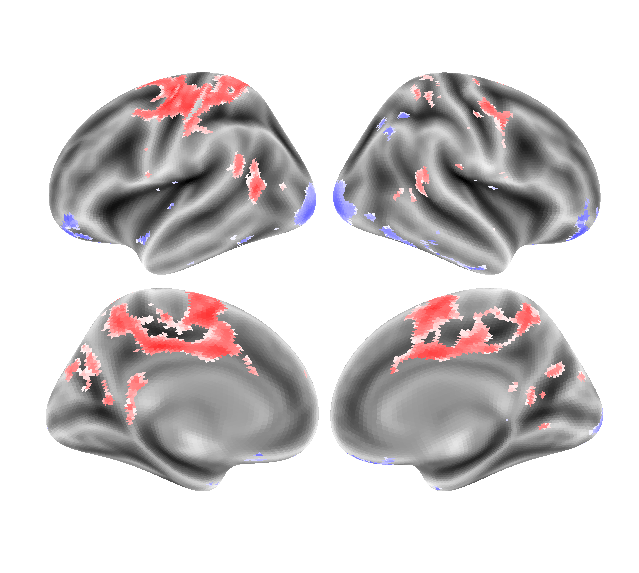

In [7]:
fig, axes = plot_surface_roi_both_hemi(img, figsize=(8,8), cmap='bwr', colorbar=False, vmin=-4, vmax=4, darkness=1)

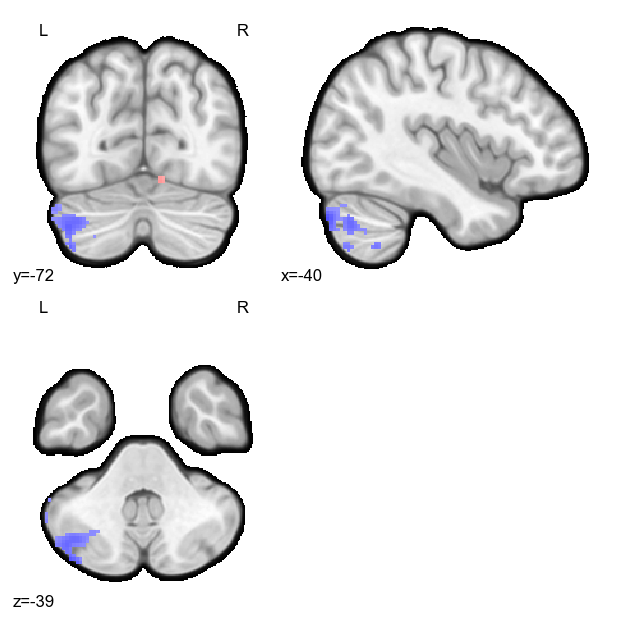

In [8]:
from nilearn.datasets import load_mni152_template, fetch_icbm152_2009
brain_file = './masks/whole_brain_mask_Sch7net400_subcortex_cerebellum_MNI152NLin2009cAsym_res-2space.nii.gz'
bdata= load_img(brain_file).get_fdata()

data = img.get_fdata()
data[bdata<=400] = 0
nimg = nib.Nifti1Image(data, img.affine)

bg_img = load_img('./masks/mni152.nii.gz')
# fig, ax = plt.subplots()
plotting.plot_img(nimg, display_mode='tiled',
                  resampling_interpolation='linear', 
                  bg_img=bg_img, cmap='bwr', 
                  threshold=0, 
                  vmin=-4,
                  vmax=4,
                  colorbar=False,
                  draw_cross=False)
fig = plt.gcf()